In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
import pickle

In [2]:
p_stories =  pickle.load( open( "clean_stories.p", "rb" ) )

In [3]:
cv_vectorizer = CountVectorizer(max_df=0.95, min_df=5, tokenizer=lambda doc: doc, lowercase=False)
cvt = cv_vectorizer.fit_transform(p_stories)

In [4]:
from sklearn.decomposition import LatentDirichletAllocation
cv_feature_names = cv_vectorizer.get_feature_names()

In [20]:
lda_model = LatentDirichletAllocation(n_components=20,               
                                      max_iter=10,                 
                                      random_state=100,          
                                      n_jobs = -1 )

In [21]:
lda_output = lda_model.fit_transform(cvt)

In [11]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [23]:
lda_output.shape

(2243679, 20)

In [46]:
pickle.dump( lda_output, open( "lda_output.p", "wb" ) )

In [3]:
lda_output = pickle.load( open( "lda_output.p", "rb" ) )

In [15]:
# Concat lda output and bert embeddings

In [2]:
emb = pickle.load( open( "emb_HN.p", "rb" ) )

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [5]:
emb = emb[1:]
#emb = torch.as_tensor(emb, dtype=torch.float32)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [7]:
scaler = MinMaxScaler(feature_range=(-1,1))
lda_o2 = scaler.fit_transform(lda_output)

In [8]:
# combine embedding and lda data
ldaemb = np.append(emb,lda_o2, axis=1)

In [9]:
class aet(nn.Module):
    def __init__(self,input_dim,hd1,hd2,hd3,hd4,drop):
        super().__init__()
        self.dropout = nn.Dropout(drop)
        self.h1 = nn.Linear(input_dim, hd1)
        self.h2 = nn.Linear(hd1,hd2)
        self.h3 = nn.Linear(hd2,hd3)
        self.h4 = nn.Linear(hd3,hd4)
        self.outl = nn.Linear(hd4,input_dim)
    def forward(self,texts):
        h1v = torch.tanh(self.dropout(self.h1(texts)))
        h2v = F.relu(self.h2(h1v))
        h3v = self.h3(h2v)
        h4v = F.relu(self.h4(h3v))
        hout = self.outl(h4v)
        return hout, h3v

In [10]:
input_dim = ldaemb.shape[1]
hd1 = 300
hd2 = 100
hd3 = 15
hd4 = 200
drop = 0.2

device = 'cuda'
model0 = aet(input_dim,hd1,hd2,hd3,hd4,drop)

In [11]:
model0.to(device)

aet(
  (dropout): Dropout(p=0.2, inplace=False)
  (h1): Linear(in_features=788, out_features=300, bias=True)
  (h2): Linear(in_features=300, out_features=100, bias=True)
  (h3): Linear(in_features=100, out_features=15, bias=True)
  (h4): Linear(in_features=15, out_features=200, bias=True)
  (outl): Linear(in_features=200, out_features=788, bias=True)
)

In [12]:
ldaemb = torch.as_tensor(ldaemb, dtype=torch.float32)

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model0.parameters(), weight_decay=0)
trainiter = DataLoader(ldaemb, batch_size=2048, shuffle=True)

In [14]:
def training(model, criterion, optimizer, trainiter, device):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trainiter):
        tin = batch.to(device)
        optimizer.zero_grad()
        recons,_ = model(tin)
        loss = criterion(recons, tin)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.item()
        
        #print(f'Batch：{i+1} | Loss: {loss.item()}')
    return epoch_loss/len(trainiter)
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
import time, math

In [16]:
N_EPOCHS = 20
CLIP = 1

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = training(model0, criterion, optimizer, trainiter, device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.7f} | Train PPL: {math.exp(train_loss):7.3f}')

Epoch: 01 | Time: 0m 12s
	Train Loss: 0.0072693 | Train PPL:   1.007
Epoch: 02 | Time: 0m 12s
	Train Loss: 0.0072525 | Train PPL:   1.007
Epoch: 03 | Time: 0m 11s
	Train Loss: 0.0072391 | Train PPL:   1.007
Epoch: 04 | Time: 0m 11s
	Train Loss: 0.0072276 | Train PPL:   1.007
Epoch: 05 | Time: 0m 11s
	Train Loss: 0.0072175 | Train PPL:   1.007
Epoch: 06 | Time: 0m 11s
	Train Loss: 0.0072088 | Train PPL:   1.007
Epoch: 07 | Time: 0m 12s
	Train Loss: 0.0072002 | Train PPL:   1.007
Epoch: 08 | Time: 0m 11s
	Train Loss: 0.0071923 | Train PPL:   1.007
Epoch: 09 | Time: 0m 11s
	Train Loss: 0.0071831 | Train PPL:   1.007
Epoch: 10 | Time: 0m 11s
	Train Loss: 0.0071744 | Train PPL:   1.007
Epoch: 11 | Time: 0m 11s
	Train Loss: 0.0071670 | Train PPL:   1.007
Epoch: 12 | Time: 0m 11s
	Train Loss: 0.0071607 | Train PPL:   1.007
Epoch: 13 | Time: 0m 11s
	Train Loss: 0.0071549 | Train PPL:   1.007
Epoch: 14 | Time: 0m 11s
	Train Loss: 0.0071474 | Train PPL:   1.007
Epoch: 15 | Time: 0m 12s
	Train Lo

In [17]:
#get the latent features out
def exlatent(model, evaliter, criterion, device):
    model.eval()
    lvars = np.zeros([1,15])
    losst = np.zeros(1)
    with torch.no_grad():
        for i, batch in enumerate(evaliter):
            tin = batch.to(device)
            recons, lvar = model(tin)
            loss = torch.sum(criterionf(recons,tin),[1])
            lvars = np.append(lvars, lvar.cpu().numpy(), axis=0)
            losst = np.append(losst,loss.cpu().numpy())
    return losst[1:], lvars[1:]

In [18]:
evaliter = DataLoader(ldaemb, batch_size=2048, shuffle=False)
criterionf  = nn.MSELoss(reduction='none')

In [19]:
losst, lvars = exlatent(model0, evaliter, criterionf, device)

In [20]:
pickle.dump( lvars, open( "ldaemb_latent.p", "wb" ) )

In [3]:
lvars = pickle.load( open( "ldaemb_latent.p", "rb" ) )

In [14]:
# clustering
from sklearn.cluster import KMeans, MiniBatchKMeans
km = KMeans(n_clusters=8, init='k-means++', max_iter=800, n_init=20, n_jobs = -1,
                verbose=1)

In [15]:
km.fit(lvars)

/usr/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 3301732.4415454236
Iteration 1, inertia 2383781.4150384297
Iteration 2, inertia 2320212.2270162734
Iteration 3, inertia 2297432.0297198603
Iteration 4, inertia 2285771.833623903
Iteration 5, inertia 2278712.0389601537
Iteration 6, inertia 2273706.836623663
Iteration 7, inertia 2269243.181860244
Iteration 8, inertia 2264372.683622226
Iteration 9, inertia 2258526.9133330393
Iteration 10, inertia 2251932.56956998
Iteration 11, inertia 2246112.766035812
Iteration 12, inertia 2241942.2504777857
Iteration 13, inertia 2239455.4652361777
Iteration 14, inertia 2237818.7107175663
Iteration 15, inertia 2236363.2105393847
Iteration 16, inertia 2234802.6220790143
Iteration 17, inertia 2233046.9963381537
Iteration 18, inertia 2231150.3345292974
Iteration 19, inertia 2229122.1689539463
Iteration 20, inertia 2226996.1358703957
Iteration 21, inertia 2224812.8119232035
Iteration 22, inertia 2222681.5554968053
Iteration 23, inertia 2220688.664509257
Iteration 

KMeans(max_iter=800, n_init=20, n_jobs=-1, verbose=1)

In [16]:
clusters = km.predict(lvars)

In [18]:
from sklearn.cluster import DBSCAN
db = DBSCAN(n_jobs=-1)

In [19]:
db.fit(lvars)

KeyboardInterrupt: 

In [8]:
stories_aug = pickle.load( open( "stories_aug.p", "rb" ) )
storyt = pd.DataFrame(stories_aug)

In [9]:
storyt['Topic'] = clusters

In [29]:
import functools
import operator
flatt = []
for i in range(0,5):
    tidx = storyt[storyt.Topic == i].index.values
    tst = p_stories[tidx]
    tstf = functools.reduce(operator.iconcat, tst, [])
    flatt.append(tstf)

In [30]:
tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)

In [31]:
vectors = tfidf.fit_transform(flatt)
names = tfidf.get_feature_names()
data = vectors.todense().tolist()
df = pd.DataFrame(data, columns=names)

In [42]:
for i in df.iterrows():
    print(i[1].sort_values(ascending=False)[:20])

s              0.442813
new            0.227756
google         0.211506
techcrunch     0.171484
m              0.171103
nytime         0.146301
apple          0.137090
startup        0.132665
bloomberg      0.130205
facebook       0.124967
arstechnica    0.108254
tech           0.106041
u              0.101596
say            0.098940
launch         0.098570
company        0.095925
theguardian    0.094587
wsj            0.090481
year           0.090152
bbc            0.089267
Name: 0, dtype: float64
github        0.599043
hn            0.293301
app           0.163744
medium        0.160986
0             0.119424
1             0.115029
code          0.114777
free          0.113991
new           0.113776
2             0.111449
build         0.106305
open          0.101982
web           0.101628
s             0.098996
release       0.095459
javascript    0.095441
python        0.092916
tool          0.092623
source        0.091399
google        0.091339
Name: 1, dtype: float64
youtube     

In [43]:
def topickey(df):
    words={}
    for sen in df:
        for word in sen:
            try:
                words[word] += 1
            except:
                words[word] =1
    t1 = sorted(words.items(), reverse=True, key=lambda x: x[1])
    t2 = ', '.join(list(zip(*t1))[0][0:10])
    print(t2)

In [3]:
import umap
reducer = umap.UMAP(low_memory=True, verbose=True)

In [4]:
uproj2 = reducer.fit_transform(lvars)

UMAP(low_memory=True, verbose=True)
Construct fuzzy simplicial set
Tue Oct 20 12:59:54 2020 Finding Nearest Neighbors
Tue Oct 20 12:59:54 2020 Building RP forest with 80 trees
Tue Oct 20 13:00:17 2020 NN descent for 21 iterations
	 0  /  21
	 1  /  21
	 2  /  21
Tue Oct 20 13:04:11 2020 Finished Nearest Neighbor Search
Tue Oct 20 13:04:25 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Oct 20 16:24:24 2020 Finished embedding


In [6]:
pickle.dump( uproj2, open( "umapldaemb.p", "wb" ) )

In [10]:
uproj2 = pickle.load( open( "umapldaemb.p", "rb" ) )

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

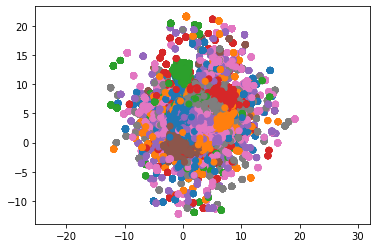

In [17]:
plt.scatter(
    uproj2[:, 0],
    uproj2[:, 1],
    c=[sns.color_palette()[x] for x in clusters])
plt.gca().set_aspect('equal', 'datalim')